# Step 2 | Build Track Recommendation Engine

The main objective of this sections of the pipeline is to build a song recommendation engine that will be then deployed on Dash or Streamlit.<br/>
In particular, the recommender will be build with the front-end UI in mind. The algorithm will follow the actions that the user will take on the app:
1. **User selects the <mark>mood/personality<mark/>** --> in the back-end a specific mood will be mapped to a specific music genre. Based on the specifie music genre, we serve the user a list of 3 songs that are the most similar to the (unknowingly) selected music genre.
2. **User selects one of the <mark>three songs<mark/>** --> we serve an optimal playlist of the day based on the 10 songs that are the most similar to the one selected by the user.
    
Therefore, the **algorithm** will be composed of three main steps:<br/>
1. Map moods/personalities to music genres
2. Recommendation Engine to output the three songs that are the most similar to a specific genre
3. Recommendation Engine to output the playlist of the day (10 songs) that are the most similar to the song selected in pt 2

In [1809]:
# initial imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from math import pi
from sklearn.metrics.pairwise import cosine_similarity
pd.options.mode.chained_assignment = None  # default='warn'
import bz2

In [150]:
# initiate sqlalchemy and create engine
from sqlalchemy import create_engine
engine = create_engine('sqlite:////Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/final/spotify.db', echo=False)

In [151]:
engine.table_names()

['albums', 'artists', 'tracks']

In [152]:
# retrieve artists data
artists_df = pd.read_sql('SELECT * FROM artists;', engine)

In [153]:
artists_df.columns

Index(['index', 'artist', 'genre'], dtype='object')

In [154]:
# drop duplicate index col
artists_df = artists_df.drop(columns = ['index'], axis=1)

In [155]:
artists_df

,artist,genre
0,Drake,rap
1,Olivia Rodrigo,pop
2,Doja Cat,dance
3,Taylor Swift,pop
4,Justin Bieber,pop
...,...,...
5262,Jiony,house
5263,The Toxic Avenger,house
5264,Myon,house
5265,Wiley,house


In [156]:
# retrieve albums data
albums_df = pd.read_sql('SELECT * FROM albums;', engine)

In [157]:
albums_df.head()

,index,album_name,album_uri,num_tracks,artist_name
0,0,Scary Hours 2,spotify:album:5LuoozUhs2pl3glZeAJl89,3,Drake
1,1,Scorpion,spotify:album:1ATL5GLyefJaxhQzSPVrLX,25,Drake
2,2,Views,spotify:album:40GMAhriYJRO1rsY4YdrZb,20,Drake
3,3,More Life,spotify:album:1lXY618HWkwYKJWBRYR4MK,22,Drake
4,4,Dark Lane Demo Tapes,spotify:album:6OQ9gBfg5EXeNAEwGSs6jK,14,Drake


In [158]:
# drop duplicate index col
albums_df = albums_df.drop(columns = ['index'], axis=1)

In [159]:
albums_df

,album_name,album_uri,num_tracks,artist_name
0,Scary Hours 2,spotify:album:5LuoozUhs2pl3glZeAJl89,3,Drake
1,Scorpion,spotify:album:1ATL5GLyefJaxhQzSPVrLX,25,Drake
2,Views,spotify:album:40GMAhriYJRO1rsY4YdrZb,20,Drake
3,More Life,spotify:album:1lXY618HWkwYKJWBRYR4MK,22,Drake
4,Dark Lane Demo Tapes,spotify:album:6OQ9gBfg5EXeNAEwGSs6jK,14,Drake
...,...,...,...,...
36973,Perfect Ghost,spotify:album:7BRmBGQ4t1kMYpNUgsv1OL,2,Myon
36974,Boasty (feat. Idris Elba),spotify:album:7JoyVaXzxpgTPjkgB8mWk3,1,Wiley
36975,"My One (feat. Tory Lanez, Kranium & Dappy)",spotify:album:1bE9v4U6xT3MDCh2SPn3jH,1,Wiley
36976,Panorama,spotify:album:4ZaeYUM5vgvkpexijZ3w2r,13,Møme


In [160]:
# retrieve tracks data
tracks_df = pd.read_sql('SELECT * FROM tracks;', engine)

In [161]:
tracks_df.head()

,index,id,album_name,track_name,artist_name,explicit,track_popularity,danceability,energy,key,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,duration_mins
0,0,3aQem4jVGdhtg116TmJnHz,Scary Hours 2,What’s Next,Drake,1,82,0.781,0.594,0,...,0.162,0.0628,129.895,audio_features,spotify:track:3aQem4jVGdhtg116TmJnHz,https://api.spotify.com/v1/tracks/3aQem4jVGdht...,https://api.spotify.com/v1/audio-analysis/3aQe...,178154,4,2.969233
1,1,65OVbaJR5O1RmwOQx0875b,Scary Hours 2,Wants and Needs (feat. Lil Baby),"Drake, Lil Baby",1,89,0.578,0.449,1,...,0.119,0.1000,136.006,audio_features,spotify:track:65OVbaJR5O1RmwOQx0875b,https://api.spotify.com/v1/tracks/65OVbaJR5O1R...,https://api.spotify.com/v1/audio-analysis/65OV...,192956,4,3.215933
2,2,4FRW5Nza1Ym91BGV4nFWXI,Scary Hours 2,Lemon Pepper Freestyle (feat. Rick Ross),"Drake, Rick Ross",1,77,0.770,0.637,1,...,0.171,0.4310,94.966,audio_features,spotify:track:4FRW5Nza1Ym91BGV4nFWXI,https://api.spotify.com/v1/tracks/4FRW5Nza1Ym9...,https://api.spotify.com/v1/audio-analysis/4FRW...,383037,4,6.383950
3,3,2yg9UN4eo5eMVJ7OB4RWj3,Scorpion,Survival,Drake,1,59,0.555,0.596,9,...,0.123,0.1450,77.324,audio_features,spotify:track:2yg9UN4eo5eMVJ7OB4RWj3,https://api.spotify.com/v1/tracks/2yg9UN4eo5eM...,https://api.spotify.com/v1/audio-analysis/2yg9...,136187,4,2.269783
4,4,0TlLq3lA83rQOYtrqBqSct,Scorpion,Nonstop,Drake,1,77,0.912,0.412,7,...,0.104,0.4230,154.983,audio_features,spotify:track:0TlLq3lA83rQOYtrqBqSct,https://api.spotify.com/v1/tracks/0TlLq3lA83rQ...,https://api.spotify.com/v1/audio-analysis/0TlL...,238614,4,3.976900


In [162]:
# drop duplicate index col
tracks_df = tracks_df.drop(columns = ['index'], axis=1)

In [163]:
tracks_df

,id,album_name,track_name,artist_name,explicit,track_popularity,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,duration_mins
0,3aQem4jVGdhtg116TmJnHz,Scary Hours 2,What’s Next,Drake,1,82,0.781,0.594,0,-6.959,...,0.1620,0.0628,129.895,audio_features,spotify:track:3aQem4jVGdhtg116TmJnHz,https://api.spotify.com/v1/tracks/3aQem4jVGdht...,https://api.spotify.com/v1/audio-analysis/3aQe...,178154,4,2.969233
1,65OVbaJR5O1RmwOQx0875b,Scary Hours 2,Wants and Needs (feat. Lil Baby),"Drake, Lil Baby",1,89,0.578,0.449,1,-6.349,...,0.1190,0.1000,136.006,audio_features,spotify:track:65OVbaJR5O1RmwOQx0875b,https://api.spotify.com/v1/tracks/65OVbaJR5O1R...,https://api.spotify.com/v1/audio-analysis/65OV...,192956,4,3.215933
2,4FRW5Nza1Ym91BGV4nFWXI,Scary Hours 2,Lemon Pepper Freestyle (feat. Rick Ross),"Drake, Rick Ross",1,77,0.770,0.637,1,-5.530,...,0.1710,0.4310,94.966,audio_features,spotify:track:4FRW5Nza1Ym91BGV4nFWXI,https://api.spotify.com/v1/tracks/4FRW5Nza1Ym9...,https://api.spotify.com/v1/audio-analysis/4FRW...,383037,4,6.383950
3,2yg9UN4eo5eMVJ7OB4RWj3,Scorpion,Survival,Drake,1,59,0.555,0.596,9,-9.090,...,0.1230,0.1450,77.324,audio_features,spotify:track:2yg9UN4eo5eMVJ7OB4RWj3,https://api.spotify.com/v1/tracks/2yg9UN4eo5eM...,https://api.spotify.com/v1/audio-analysis/2yg9...,136187,4,2.269783
4,0TlLq3lA83rQOYtrqBqSct,Scorpion,Nonstop,Drake,1,77,0.912,0.412,7,-8.074,...,0.1040,0.4230,154.983,audio_features,spotify:track:0TlLq3lA83rQOYtrqBqSct,https://api.spotify.com/v1/tracks/0TlLq3lA83rQ...,https://api.spotify.com/v1/audio-analysis/0TlL...,238614,4,3.976900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346552,6VP69eiW8k8OVUjS2lBYKy,Rise of the Blood Legion- The Best of (Chapter 1),Adrenalize,In This Moment,0,30,0.443,0.960,6,-3.933,...,0.1310,0.4320,132.190,audio_features,spotify:track:6VP69eiW8k8OVUjS2lBYKy,https://api.spotify.com/v1/tracks/6VP69eiW8k8O...,https://api.spotify.com/v1/audio-analysis/6VP6...,255653,4,4.260883
346553,3GrFAJiT7FWRBKuLqVHy3b,Rise of the Blood Legion- The Best of (Chapter 1),It is Written,In This Moment,1,19,0.299,0.762,1,-15.699,...,0.6070,0.1570,80.819,audio_features,spotify:track:3GrFAJiT7FWRBKuLqVHy3b,https://api.spotify.com/v1/tracks/3GrFAJiT7FWR...,https://api.spotify.com/v1/audio-analysis/3GrF...,30227,4,0.503783
346554,326QxhmInOvbgbaNzeHxRz,Rise of the Blood Legion- The Best of (Chapter 1),Burn,In This Moment,0,27,0.358,0.819,4,-5.256,...,0.1050,0.0452,146.093,audio_features,spotify:track:326QxhmInOvbgbaNzeHxRz,https://api.spotify.com/v1/tracks/326QxhmInOvb...,https://api.spotify.com/v1/audio-analysis/326Q...,284693,4,4.744883
346555,5hamZeMqIFSZbEgQ2kQ9IN,Rise of the Blood Legion- The Best of (Chapter 1),Whore,In This Moment,1,33,0.474,0.884,6,-3.845,...,0.0783,0.5240,179.559,audio_features,spotify:track:5hamZeMqIFSZbEgQ2kQ9IN,https://api.spotify.com/v1/tracks/5hamZeMqIFSZ...,https://api.spotify.com/v1/audio-analysis/5ham...,245960,4,4.099333


## Preprocessing

As a first step, we will preprocess the track-realated music features data in preparation for the modeling phase. To include *genre* as part of the *tracks_df*, we will need to merge the *tracks* and the *artists* dataframes on the artist column, since on Spotify **genre is established at the artist level**.

In [164]:
# check album names where Drake is the primary artist
albums_df[albums_df['artist_name'].str.contains('Drake')]

,album_name,album_uri,num_tracks,artist_name
0,Scary Hours 2,spotify:album:5LuoozUhs2pl3glZeAJl89,3,Drake
1,Scorpion,spotify:album:1ATL5GLyefJaxhQzSPVrLX,25,Drake
2,Views,spotify:album:40GMAhriYJRO1rsY4YdrZb,20,Drake
3,More Life,spotify:album:1lXY618HWkwYKJWBRYR4MK,22,Drake
4,Dark Lane Demo Tapes,spotify:album:6OQ9gBfg5EXeNAEwGSs6jK,14,Drake
5,If You're Reading This It's Too Late,spotify:album:0ptlfJfwGTy0Yvrk14JK1I,17,Drake
6,Laugh Now Cry Later (feat. Lil Durk),spotify:album:0qGdc7fNq9RNIPEzZufa43,1,Drake
7,Nothing Was The Same,spotify:album:1XslIirSxfAhhxRdn4Li9t,13,Drake
5000,The Truth Hurts,spotify:album:2bY51cinHBlscXIoLUsDYa,17,Drakeo the Ruler
5001,Cold Devil,spotify:album:6Kj3V2xkTfomOJJ9uK8yin,16,Drakeo the Ruler


In [165]:
# check track names where Drake is the primary artist
tracks_df[tracks_df['artist_name'].str.contains('Drake')]

,id,album_name,track_name,artist_name,explicit,track_popularity,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,duration_mins
0,3aQem4jVGdhtg116TmJnHz,Scary Hours 2,What’s Next,Drake,1,82,0.781,0.594,0,-6.959,...,0.162,0.0628,129.895,audio_features,spotify:track:3aQem4jVGdhtg116TmJnHz,https://api.spotify.com/v1/tracks/3aQem4jVGdht...,https://api.spotify.com/v1/audio-analysis/3aQe...,178154,4,2.969233
1,65OVbaJR5O1RmwOQx0875b,Scary Hours 2,Wants and Needs (feat. Lil Baby),"Drake, Lil Baby",1,89,0.578,0.449,1,-6.349,...,0.119,0.1000,136.006,audio_features,spotify:track:65OVbaJR5O1RmwOQx0875b,https://api.spotify.com/v1/tracks/65OVbaJR5O1R...,https://api.spotify.com/v1/audio-analysis/65OV...,192956,4,3.215933
2,4FRW5Nza1Ym91BGV4nFWXI,Scary Hours 2,Lemon Pepper Freestyle (feat. Rick Ross),"Drake, Rick Ross",1,77,0.770,0.637,1,-5.530,...,0.171,0.4310,94.966,audio_features,spotify:track:4FRW5Nza1Ym91BGV4nFWXI,https://api.spotify.com/v1/tracks/4FRW5Nza1Ym9...,https://api.spotify.com/v1/audio-analysis/4FRW...,383037,4,6.383950
3,2yg9UN4eo5eMVJ7OB4RWj3,Scorpion,Survival,Drake,1,59,0.555,0.596,9,-9.090,...,0.123,0.1450,77.324,audio_features,spotify:track:2yg9UN4eo5eMVJ7OB4RWj3,https://api.spotify.com/v1/tracks/2yg9UN4eo5eM...,https://api.spotify.com/v1/audio-analysis/2yg9...,136187,4,2.269783
4,0TlLq3lA83rQOYtrqBqSct,Scorpion,Nonstop,Drake,1,77,0.912,0.412,7,-8.074,...,0.104,0.4230,154.983,audio_features,spotify:track:0TlLq3lA83rQOYtrqBqSct,https://api.spotify.com/v1/tracks/0TlLq3lA83rQ...,https://api.spotify.com/v1/audio-analysis/0TlL...,238614,4,3.976900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219466,24SDeYAeTFda8OUzVI1VR6,FIXTAPE,TWIST & TURN (feat. Drake & PARTYNEXTDOOR),"Popcaan, Drake, PARTYNEXTDOOR",0,69,0.571,0.747,7,-4.659,...,0.116,0.6350,106.253,audio_features,spotify:track:24SDeYAeTFda8OUzVI1VR6,https://api.spotify.com/v1/tracks/24SDeYAeTFda...,https://api.spotify.com/v1/audio-analysis/24SD...,259651,4,4.327517
219473,5s0e986tlNvseDl2YydUc6,FIXTAPE,ALL I NEED (feat. Drake),"Popcaan, Drake",1,59,0.573,0.427,10,-9.000,...,0.101,0.1270,91.405,audio_features,spotify:track:5s0e986tlNvseDl2YydUc6,https://api.spotify.com/v1/tracks/5s0e986tlNvs...,https://api.spotify.com/v1/audio-analysis/5s0e...,177899,4,2.964983
249369,2pb60TH00uLrtPFUNVknn8,Late Night Tales: The Cinematic Orchestra,Three Hours,Nick Drake,0,26,0.444,0.216,7,-19.092,...,0.119,0.1270,118.913,audio_features,spotify:track:2pb60TH00uLrtPFUNVknn8,https://api.spotify.com/v1/tracks/2pb60TH00uLr...,https://api.spotify.com/v1/audio-analysis/2pb6...,423021,4,7.050350
316421,5EMKS6mLi4JprJxy8IGdhT,Dear America,DnF (feat. Drake & Future),"Preme, Drake, Future",1,57,0.707,0.599,0,-7.053,...,0.310,0.5500,76.881,audio_features,spotify:track:5EMKS6mLi4JprJxy8IGdhT,https://api.spotify.com/v1/tracks/5EMKS6mLi4Jp...,https://api.spotify.com/v1/audio-analysis/5EMK...,205387,4,3.423117


Now, we want to add the column *genre* to the *tracks* dataframe. The assignment of music genre is based on the artist, in alignment with how Spotify defines genre (at the artist level). It's important to note that there is a slight discrepancy between the **<mark>artist_name<mark/>** in the *album* and *artist* tables in comparison with the *tracks* table:
- *Artist* / *Album* tables: *artist_name* column contain only the name of the main artist that released an album (e.g. Drake for the album "Scary Hours 2")
- *Tracks* table: *artist_name* column contain also secondary artists that collaborated to create a specific track (e.g. Drake and Lil Baby for the track "Wants and Needs (feat. Lil Baby)" within the album "Scary Hours 2"
    
Therefore, we will need to manipulate the column *artist_name* in the *tracks_df* to make sure we can then execute the merge with the *artist_df* on the same column *artist_name*.

In [166]:
# rename col in albums_df so we can use it in the artist_name manipulation of the tracks_df col
albums_df = albums_df.rename(columns={'artist_name': 'artist'})

In [172]:
albums_df.columns

Index(['album_name', 'album_uri', 'num_tracks', 'artist'], dtype='object')

In [167]:
tracks_df.columns

Index(['id', 'album_name', 'track_name', 'artist_name', 'explicit',
       'track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'duration_mins'],
      dtype='object')

> Before merging albums and tracks df we need to **check for duplicates**.

In [173]:
# check for duplicate albums
albums_df['album_uri'].duplicated().any()

False

In [169]:
# check for duplicate tracks
tracks_df['id'].duplicated().any()

False

> Both albums and tracks dfs seem to have unique items only and no duplicates. However, the merge between albums and tracks df will have to be executed on the combination of artist and album names. So, we need to **check for the uniqueness of the combination of artist and album names** in the albums df.

In [253]:
artists_df.columns

Index(['artist', 'genre'], dtype='object')

Let's now check the uniqueness of the combination of artist and album name.

In [698]:
grouped_albums = albums_df.groupby(['artist','album_name']).size().reset_index().rename(columns={0:'count'})

In [699]:
grouped_albums['count'].value_counts()

1    35600
2      659
3       18
6        1
Name: count, dtype: int64

> Artist and album combinations are **not unique**. We'll have to apply some data manipulation to merge the genre column (from the artist or album df) onto the tracks df.

Because of its more straightforward match, I have decided to merge the artists and the tracks dataframes (and effectively add the *genre* column onto the tracks df) on the column *artist*. As we know, in the artists df only the primary artist is shown in the column *artist*, while in the tracks df both primary and collaborating artists are shown in the column *artist*. Therefore, we'll have to add a couple of manipulations in order to be able to execute the merge.

We will proceed as follows:
- In the *tracks_df*, create column *artist split* including the list of all artists that created the track in question
- Check for the match between the elements of the *artist_split* col and the artist mentioned in the *artist* col in the artist dataframe
- If match is found, return primary artist mentioned in the *artist* col in the artist dataframe
- Merge artist df and tracks df on *artist* column

In [700]:
# split artists in list
tracks_df['artists_split'] = tracks_df['artist_name'].apply(lambda x: [y.strip() for y in x.split(',')])

In [911]:
# merge genre col in album_df
albums_df = albums_df.merge(artists_df, on ='artist', how='left')

Let's now concatenate album and artist to ensure that the merge between albums and tracks df will be exact. This is due to the fact that, as we saw, multiple artists might be associated with the same album name. 

In [928]:
# create new col as concatenation of album and artist
albums_df['album_artist'] = albums_df['album_name'].apply(lambda x: x.split()) + albums_df['artist'].apply(lambda x: x.split())

In [929]:
albums_df.head()

,album_name,album_uri,num_tracks,artist,genre,album_artist
0,Scary Hours 2,spotify:album:5LuoozUhs2pl3glZeAJl89,3,Drake,rap,"[Scary, Hours, 2, Drake]"
1,Scorpion,spotify:album:1ATL5GLyefJaxhQzSPVrLX,25,Drake,rap,"[Scorpion, Drake]"
2,Views,spotify:album:40GMAhriYJRO1rsY4YdrZb,20,Drake,rap,"[Views, Drake]"
3,More Life,spotify:album:1lXY618HWkwYKJWBRYR4MK,22,Drake,rap,"[More, Life, Drake]"
4,Dark Lane Demo Tapes,spotify:album:6OQ9gBfg5EXeNAEwGSs6jK,14,Drake,rap,"[Dark, Lane, Demo, Tapes, Drake]"


In [932]:
# create new col as concatenation of album and artist
tracks_df['alb_art'] = tracks_df['artists_split'] + tracks_df['album_name'].apply(lambda x: x.split())

In [933]:
tracks_df.head()

,id,album_name,track_name,artist_name,explicit,track_popularity,danceability,energy,key,loudness,...,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,duration_mins,artists_split,alb_art
0,3aQem4jVGdhtg116TmJnHz,Scary Hours 2,What’s Next,Drake,1,82,0.781,0.594,0,-6.959,...,129.895,audio_features,spotify:track:3aQem4jVGdhtg116TmJnHz,https://api.spotify.com/v1/tracks/3aQem4jVGdht...,https://api.spotify.com/v1/audio-analysis/3aQe...,178154,4,2.969233,[Drake],"[Drake, Scary, Hours, 2]"
1,65OVbaJR5O1RmwOQx0875b,Scary Hours 2,Wants and Needs (feat. Lil Baby),"Drake, Lil Baby",1,89,0.578,0.449,1,-6.349,...,136.006,audio_features,spotify:track:65OVbaJR5O1RmwOQx0875b,https://api.spotify.com/v1/tracks/65OVbaJR5O1R...,https://api.spotify.com/v1/audio-analysis/65OV...,192956,4,3.215933,"[Drake, Lil Baby]","[Drake, Lil Baby, Scary, Hours, 2]"
2,4FRW5Nza1Ym91BGV4nFWXI,Scary Hours 2,Lemon Pepper Freestyle (feat. Rick Ross),"Drake, Rick Ross",1,77,0.770,0.637,1,-5.530,...,94.966,audio_features,spotify:track:4FRW5Nza1Ym91BGV4nFWXI,https://api.spotify.com/v1/tracks/4FRW5Nza1Ym9...,https://api.spotify.com/v1/audio-analysis/4FRW...,383037,4,6.383950,"[Drake, Rick Ross]","[Drake, Rick Ross, Scary, Hours, 2]"
3,2yg9UN4eo5eMVJ7OB4RWj3,Scorpion,Survival,Drake,1,59,0.555,0.596,9,-9.090,...,77.324,audio_features,spotify:track:2yg9UN4eo5eMVJ7OB4RWj3,https://api.spotify.com/v1/tracks/2yg9UN4eo5eM...,https://api.spotify.com/v1/audio-analysis/2yg9...,136187,4,2.269783,[Drake],"[Drake, Scorpion]"
4,0TlLq3lA83rQOYtrqBqSct,Scorpion,Nonstop,Drake,1,77,0.912,0.412,7,-8.074,...,154.983,audio_features,spotify:track:0TlLq3lA83rQOYtrqBqSct,https://api.spotify.com/v1/tracks/0TlLq3lA83rQ...,https://api.spotify.com/v1/audio-analysis/0TlL...,238614,4,3.976900,[Drake],"[Drake, Scorpion]"


In [1128]:
# concatenate col genre from album df into the tracks df
def get_genre(track_id, df_songs = tracks_df, df_albums = albums_df):
    
    index = df_songs[df_songs['id'] == track_id].index[0]
    track_album_set = set(df_songs.iloc[index]['alb_art'])
    
    for i in range(df_albums.shape[0]):
        if set(df_albums.iloc[i]['album_artist']).issubset(track_album_set):
            genre = df_albums.iloc[i]['genre']
            break
        else:
            genre = None
    
    return genre

In [1130]:
# tracks_df['genre'] = tracks_df['id'].apply(get_genre)

The line of code above kept running for a few hours, which is clearly not sustainable for the task at hand. So, I decided to pickle the dataframes and **<mark>execute the function on Colab<mark/>**. In the meantime, I will run the recommender engine on this notebook by using a reduced tracks dataframe.

In [1131]:
# pickle to use on colab
albums_df.to_pickle('albums.pkl')

In [1132]:
# pickle to use on colab
artists_df.to_pickle('artists.pkl')

In [1133]:
# pickle to use on colab
tracks_df.to_pickle('tracks.pkl')

In [1140]:
# rename col in artists_df
artists_df.rename(columns={'artist': 'artist_name'},inplace=True)

In [1175]:
# temporary df where genre col is concatenated from the artists df to the tracks df
tracks_temp = tracks_df.merge(artists_df[['artist_name','genre']], on = 'artist_name', how = 'left')

In [1176]:
tracks_temp

,id,album_name,track_name,artist_name,explicit,track_popularity,danceability,energy,key,loudness,...,type,uri,track_href,analysis_url,duration_ms,time_signature,duration_mins,artists_split,alb_art,genre
0,3aQem4jVGdhtg116TmJnHz,Scary Hours 2,What’s Next,Drake,1,82,0.781,0.594,0,-6.959,...,audio_features,spotify:track:3aQem4jVGdhtg116TmJnHz,https://api.spotify.com/v1/tracks/3aQem4jVGdht...,https://api.spotify.com/v1/audio-analysis/3aQe...,178154,4,2.969233,[Drake],"[Drake, Scary, Hours, 2]",rap
1,65OVbaJR5O1RmwOQx0875b,Scary Hours 2,Wants and Needs (feat. Lil Baby),"Drake, Lil Baby",1,89,0.578,0.449,1,-6.349,...,audio_features,spotify:track:65OVbaJR5O1RmwOQx0875b,https://api.spotify.com/v1/tracks/65OVbaJR5O1R...,https://api.spotify.com/v1/audio-analysis/65OV...,192956,4,3.215933,"[Drake, Lil Baby]","[Drake, Lil Baby, Scary, Hours, 2]",NaN
2,4FRW5Nza1Ym91BGV4nFWXI,Scary Hours 2,Lemon Pepper Freestyle (feat. Rick Ross),"Drake, Rick Ross",1,77,0.770,0.637,1,-5.530,...,audio_features,spotify:track:4FRW5Nza1Ym91BGV4nFWXI,https://api.spotify.com/v1/tracks/4FRW5Nza1Ym9...,https://api.spotify.com/v1/audio-analysis/4FRW...,383037,4,6.383950,"[Drake, Rick Ross]","[Drake, Rick Ross, Scary, Hours, 2]",NaN
3,2yg9UN4eo5eMVJ7OB4RWj3,Scorpion,Survival,Drake,1,59,0.555,0.596,9,-9.090,...,audio_features,spotify:track:2yg9UN4eo5eMVJ7OB4RWj3,https://api.spotify.com/v1/tracks/2yg9UN4eo5eM...,https://api.spotify.com/v1/audio-analysis/2yg9...,136187,4,2.269783,[Drake],"[Drake, Scorpion]",rap
4,0TlLq3lA83rQOYtrqBqSct,Scorpion,Nonstop,Drake,1,77,0.912,0.412,7,-8.074,...,audio_features,spotify:track:0TlLq3lA83rQOYtrqBqSct,https://api.spotify.com/v1/tracks/0TlLq3lA83rQ...,https://api.spotify.com/v1/audio-analysis/0TlL...,238614,4,3.976900,[Drake],"[Drake, Scorpion]",rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346552,6VP69eiW8k8OVUjS2lBYKy,Rise of the Blood Legion- The Best of (Chapter 1),Adrenalize,In This Moment,0,30,0.443,0.960,6,-3.933,...,audio_features,spotify:track:6VP69eiW8k8OVUjS2lBYKy,https://api.spotify.com/v1/tracks/6VP69eiW8k8O...,https://api.spotify.com/v1/audio-analysis/6VP6...,255653,4,4.260883,[In This Moment],"[In This Moment, Rise, of, the, Blood, Legion-...",metal
346553,3GrFAJiT7FWRBKuLqVHy3b,Rise of the Blood Legion- The Best of (Chapter 1),It is Written,In This Moment,1,19,0.299,0.762,1,-15.699,...,audio_features,spotify:track:3GrFAJiT7FWRBKuLqVHy3b,https://api.spotify.com/v1/tracks/3GrFAJiT7FWR...,https://api.spotify.com/v1/audio-analysis/3GrF...,30227,4,0.503783,[In This Moment],"[In This Moment, Rise, of, the, Blood, Legion-...",metal
346554,326QxhmInOvbgbaNzeHxRz,Rise of the Blood Legion- The Best of (Chapter 1),Burn,In This Moment,0,27,0.358,0.819,4,-5.256,...,audio_features,spotify:track:326QxhmInOvbgbaNzeHxRz,https://api.spotify.com/v1/tracks/326QxhmInOvb...,https://api.spotify.com/v1/audio-analysis/326Q...,284693,4,4.744883,[In This Moment],"[In This Moment, Rise, of, the, Blood, Legion-...",metal
346555,5hamZeMqIFSZbEgQ2kQ9IN,Rise of the Blood Legion- The Best of (Chapter 1),Whore,In This Moment,1,33,0.474,0.884,6,-3.845,...,audio_features,spotify:track:5hamZeMqIFSZbEgQ2kQ9IN,https://api.spotify.com/v1/tracks/5hamZeMqIFSZ...,https://api.spotify.com/v1/audio-analysis/5ham...,245960,4,4.099333,[In This Moment],"[In This Moment, Rise, of, the, Blood, Legion-...",metal


In [1177]:
tracks_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346557 entries, 0 to 346556
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                346557 non-null  object 
 1   album_name        346557 non-null  object 
 2   track_name        346557 non-null  object 
 3   artist_name       346557 non-null  object 
 4   explicit          346557 non-null  int64  
 5   track_popularity  346557 non-null  int64  
 6   danceability      346557 non-null  float64
 7   energy            346557 non-null  float64
 8   key               346557 non-null  int64  
 9   loudness          346557 non-null  float64
 10  mode              346557 non-null  int64  
 11  speechiness       346557 non-null  float64
 12  acousticness      346557 non-null  float64
 13  instrumentalness  346557 non-null  float64
 14  liveness          346557 non-null  float64
 15  valence           346557 non-null  float64
 16  tempo             34

In [1178]:
# check for nulls
tracks_temp.isnull().values.sum()

90920

> It's important to note that the genre col has around **90k Null values**. This is due to the fact that the artist df presents only primary artists in the artist column (i.e. only one artist per row), while the tracks df presents both primary and secondary artists in the artist column (i.e. multiple artists per row). Since at Spotify the genre is assigned at the artist level, we know that this merge is **<mark>very accurate<mark/>** (i.e. genre assigned in the tracks df only when the primary artist was found) at the expense of **<mark>some missing data<mark/>** . We will continue operating on this accurate but smaller dataframe until the operation of merging by album name and artist is executed on Colab. The new and larger dataframe will be treated in a different notebook in a second time. 

In [1179]:
# drop nulls 
tracks_temp.dropna(inplace=True)

In [1180]:
tracks_temp.shape

(255637, 27)

In [1181]:
# check for nulls
tracks_temp.isnull().values.sum()

0

In [1182]:
# check for duplicates
tracks_temp['id'].is_unique

True

In [1192]:
# reset index
tracks_temp.reset_index(drop=True,inplace=True)

In [1193]:
tracks_temp

,id,album_name,track_name,artist_name,explicit,track_popularity,danceability,energy,key,loudness,...,type,uri,track_href,analysis_url,duration_ms,time_signature,duration_mins,artists_split,alb_art,genre
0,3aQem4jVGdhtg116TmJnHz,Scary Hours 2,What’s Next,Drake,1,82,0.781,0.594,0,-6.959,...,audio_features,spotify:track:3aQem4jVGdhtg116TmJnHz,https://api.spotify.com/v1/tracks/3aQem4jVGdht...,https://api.spotify.com/v1/audio-analysis/3aQe...,178154,4,2.969233,[Drake],"[Drake, Scary, Hours, 2]",rap
1,2yg9UN4eo5eMVJ7OB4RWj3,Scorpion,Survival,Drake,1,59,0.555,0.596,9,-9.090,...,audio_features,spotify:track:2yg9UN4eo5eMVJ7OB4RWj3,https://api.spotify.com/v1/tracks/2yg9UN4eo5eM...,https://api.spotify.com/v1/audio-analysis/2yg9...,136187,4,2.269783,[Drake],"[Drake, Scorpion]",rap
2,0TlLq3lA83rQOYtrqBqSct,Scorpion,Nonstop,Drake,1,77,0.912,0.412,7,-8.074,...,audio_features,spotify:track:0TlLq3lA83rQOYtrqBqSct,https://api.spotify.com/v1/tracks/0TlLq3lA83rQ...,https://api.spotify.com/v1/audio-analysis/0TlL...,238614,4,3.976900,[Drake],"[Drake, Scorpion]",rap
3,3szf2z1Cy1QMrtHrbn8rz9,Scorpion,Elevate,Drake,1,62,0.758,0.474,1,-8.720,...,audio_features,spotify:track:3szf2z1Cy1QMrtHrbn8rz9,https://api.spotify.com/v1/tracks/3szf2z1Cy1QM...,https://api.spotify.com/v1/audio-analysis/3szf...,184960,4,3.082667,[Drake],"[Drake, Scorpion]",rap
4,5Psnhdkyanjpgc2P8A5TSM,Scorpion,Emotionless,Drake,1,65,0.414,0.677,1,-5.120,...,audio_features,spotify:track:5Psnhdkyanjpgc2P8A5TSM,https://api.spotify.com/v1/tracks/5Psnhdkyanjp...,https://api.spotify.com/v1/audio-analysis/5Psn...,302173,4,5.036217,[Drake],"[Drake, Scorpion]",rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255632,6VP69eiW8k8OVUjS2lBYKy,Rise of the Blood Legion- The Best of (Chapter 1),Adrenalize,In This Moment,0,30,0.443,0.960,6,-3.933,...,audio_features,spotify:track:6VP69eiW8k8OVUjS2lBYKy,https://api.spotify.com/v1/tracks/6VP69eiW8k8O...,https://api.spotify.com/v1/audio-analysis/6VP6...,255653,4,4.260883,[In This Moment],"[In This Moment, Rise, of, the, Blood, Legion-...",metal
255633,3GrFAJiT7FWRBKuLqVHy3b,Rise of the Blood Legion- The Best of (Chapter 1),It is Written,In This Moment,1,19,0.299,0.762,1,-15.699,...,audio_features,spotify:track:3GrFAJiT7FWRBKuLqVHy3b,https://api.spotify.com/v1/tracks/3GrFAJiT7FWR...,https://api.spotify.com/v1/audio-analysis/3GrF...,30227,4,0.503783,[In This Moment],"[In This Moment, Rise, of, the, Blood, Legion-...",metal
255634,326QxhmInOvbgbaNzeHxRz,Rise of the Blood Legion- The Best of (Chapter 1),Burn,In This Moment,0,27,0.358,0.819,4,-5.256,...,audio_features,spotify:track:326QxhmInOvbgbaNzeHxRz,https://api.spotify.com/v1/tracks/326QxhmInOvb...,https://api.spotify.com/v1/audio-analysis/326Q...,284693,4,4.744883,[In This Moment],"[In This Moment, Rise, of, the, Blood, Legion-...",metal
255635,5hamZeMqIFSZbEgQ2kQ9IN,Rise of the Blood Legion- The Best of (Chapter 1),Whore,In This Moment,1,33,0.474,0.884,6,-3.845,...,audio_features,spotify:track:5hamZeMqIFSZbEgQ2kQ9IN,https://api.spotify.com/v1/tracks/5hamZeMqIFSZ...,https://api.spotify.com/v1/audio-analysis/5ham...,245960,4,4.099333,[In This Moment],"[In This Moment, Rise, of, the, Blood, Legion-...",metal


In [1194]:
tracks_temp.columns

Index(['id', 'album_name', 'track_name', 'artist_name', 'explicit',
       'track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'duration_mins', 'artists_split',
       'alb_art', 'genre'],
      dtype='object')

In [1200]:
# select only music features we're interested in
track_features = tracks_temp[['id','track_name','artist_name','album_name',
                            'genre','track_popularity','danceability', 
                            'energy', 'loudness','speechiness', 'acousticness',
                            'duration_mins','instrumentalness','liveness', 
                            'valence', 'tempo']]

Let's take some time to go through the selected music features. For additional context, see the official documentation [here](https://developer.spotify.com/documentation/web-api/reference/#category-tracks):
- **Popularity**: based on an algorithm built on the total number of plays the track has had and how recent those plays are. Ranges from 0 (low popularity) to 100 (high popularity). 
- **Danceability**: suitability of a track for dancing based on tempo, rhythm stability, beat strength, and overall regularity. Ranges from 0 (low danceability) to 1 (high danceability). 
- **Energy**: perceptual measure of intensity and activity. Ranges from 0 (low energy) to 1 (high energy).
- **Loudness**: overall loudness of a track in decibels (dB). Ranges between -60 (high loudness) and 0 db (low lowdness).
- **Speechiness**: presence of spoken words in a track. Ranges from 0 (low speechiness) to 1 (high speechiness).
- **Acousticness**: confidence measure of whether the track is acoustic. Ranges from 0 (low confidence in acousticness) to 1 (high confidence in acousticness).
- **Duration mins**: duration of the track in minutes.
- **Instrumentalness**: predicts whether a track contains no vocals. Ranges from 0 (lower likelihood the track contains no vocal content) to 1 (greater likelihood the track contains no vocal content).
- **Liveness**: presence of an audience in the recording. Ranges from 0 (lower likelihood that there is live audience) to 1 (higher likelihood that there is live audience).
- **Valence**: musical positiveness conveyed by a track. Ranges from 0 (not positive) to 1 (positive).
- **Tempo**: overall estimated tempo of a track in beats per minute (BPM).

> Music features are on different scales. We will then apply **normalization**, a scaling technique that will cause the values to be shifted and finally range between 0 and 1.

In [1201]:
track_features

,id,track_name,artist_name,album_name,genre,track_popularity,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
0,3aQem4jVGdhtg116TmJnHz,What’s Next,Drake,Scary Hours 2,rap,82,0.781,0.594,-6.959,0.0485,0.013600,2.969233,0.000000,0.1620,0.0628,129.895
1,2yg9UN4eo5eMVJ7OB4RWj3,Survival,Drake,Scorpion,rap,59,0.555,0.596,-9.090,0.3750,0.133000,2.269783,0.000000,0.1230,0.1450,77.324
2,0TlLq3lA83rQOYtrqBqSct,Nonstop,Drake,Scorpion,rap,77,0.912,0.412,-8.074,0.1230,0.016500,3.976900,0.012600,0.1040,0.4230,154.983
3,3szf2z1Cy1QMrtHrbn8rz9,Elevate,Drake,Scorpion,rap,62,0.758,0.474,-8.720,0.1470,0.015200,3.082667,0.000000,0.1160,0.0542,76.061
4,5Psnhdkyanjpgc2P8A5TSM,Emotionless,Drake,Scorpion,rap,65,0.414,0.677,-5.120,0.2540,0.024800,5.036217,0.000000,0.0793,0.0853,172.521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255632,6VP69eiW8k8OVUjS2lBYKy,Adrenalize,In This Moment,Rise of the Blood Legion- The Best of (Chapter 1),metal,30,0.443,0.960,-3.933,0.0872,0.000236,4.260883,0.000000,0.1310,0.4320,132.190
255633,3GrFAJiT7FWRBKuLqVHy3b,It is Written,In This Moment,Rise of the Blood Legion- The Best of (Chapter 1),metal,19,0.299,0.762,-15.699,0.9140,0.055900,0.503783,0.377000,0.6070,0.1570,80.819
255634,326QxhmInOvbgbaNzeHxRz,Burn,In This Moment,Rise of the Blood Legion- The Best of (Chapter 1),metal,27,0.358,0.819,-5.256,0.0606,0.002710,4.744883,0.003870,0.1050,0.0452,146.093
255635,5hamZeMqIFSZbEgQ2kQ9IN,Whore,In This Moment,Rise of the Blood Legion- The Best of (Chapter 1),metal,33,0.474,0.884,-3.845,0.1010,0.025400,4.099333,0.000000,0.0783,0.5240,179.559


In [1202]:
track_features.head()

,id,track_name,artist_name,album_name,genre,track_popularity,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
0,3aQem4jVGdhtg116TmJnHz,What’s Next,Drake,Scary Hours 2,rap,82,0.781,0.594,-6.959,0.0485,0.0136,2.969233,0.0000,0.1620,0.0628,129.895
1,2yg9UN4eo5eMVJ7OB4RWj3,Survival,Drake,Scorpion,rap,59,0.555,0.596,-9.090,0.3750,0.1330,2.269783,0.0000,0.1230,0.1450,77.324
2,0TlLq3lA83rQOYtrqBqSct,Nonstop,Drake,Scorpion,rap,77,0.912,0.412,-8.074,0.1230,0.0165,3.976900,0.0126,0.1040,0.4230,154.983
3,3szf2z1Cy1QMrtHrbn8rz9,Elevate,Drake,Scorpion,rap,62,0.758,0.474,-8.720,0.1470,0.0152,3.082667,0.0000,0.1160,0.0542,76.061
4,5Psnhdkyanjpgc2P8A5TSM,Emotionless,Drake,Scorpion,rap,65,0.414,0.677,-5.120,0.2540,0.0248,5.036217,0.0000,0.0793,0.0853,172.521


Let's now **normalize music features** by using the MinMaxScaler() method, which will reshape them to a 0-1 range. 

In [1203]:
music_features = ['danceability','energy', 'loudness','speechiness', 'acousticness',
                  'duration_mins','instrumentalness','liveness', 'valence', 'tempo']

In [1204]:
# normalize music features
mms = MinMaxScaler()
track_features[music_features] = mms.fit_transform(track_features[music_features])

In [1205]:
track_features

,id,track_name,artist_name,album_name,genre,track_popularity,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
0,3aQem4jVGdhtg116TmJnHz,What’s Next,Drake,Scary Hours 2,rap,82,0.790486,0.594,0.819698,0.050103,0.013655,0.037316,0.000000,0.1620,0.0628,0.532182
1,2yg9UN4eo5eMVJ7OB4RWj3,Survival,Drake,Scorpion,rap,59,0.561741,0.596,0.786765,0.387397,0.133534,0.028405,0.000000,0.1230,0.1450,0.316798
2,0TlLq3lA83rQOYtrqBqSct,Nonstop,Drake,Scorpion,rap,77,0.923077,0.412,0.802466,0.127066,0.016566,0.050154,0.012613,0.1040,0.4230,0.634968
3,3szf2z1Cy1QMrtHrbn8rz9,Elevate,Drake,Scorpion,rap,62,0.767206,0.474,0.792483,0.151860,0.015261,0.038761,0.000000,0.1160,0.0542,0.311623
4,5Psnhdkyanjpgc2P8A5TSM,Emotionless,Drake,Scorpion,rap,65,0.419028,0.677,0.848118,0.262397,0.024900,0.063650,0.000000,0.0793,0.0853,0.706822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255632,6VP69eiW8k8OVUjS2lBYKy,Adrenalize,In This Moment,Rise of the Blood Legion- The Best of (Chapter 1),metal,30,0.448381,0.960,0.866462,0.090083,0.000237,0.053772,0.000000,0.1310,0.4320,0.541585
255633,3GrFAJiT7FWRBKuLqVHy3b,It is Written,In This Moment,Rise of the Blood Legion- The Best of (Chapter 1),metal,19,0.302632,0.762,0.684629,0.944215,0.056124,0.005906,0.377377,0.6070,0.1570,0.331117
255634,326QxhmInOvbgbaNzeHxRz,Burn,In This Moment,Rise of the Blood Legion- The Best of (Chapter 1),metal,27,0.362348,0.819,0.846016,0.062603,0.002721,0.059938,0.003874,0.1050,0.0452,0.598546
255635,5hamZeMqIFSZbEgQ2kQ9IN,Whore,In This Moment,Rise of the Blood Legion- The Best of (Chapter 1),metal,33,0.479757,0.884,0.867822,0.104339,0.025502,0.051714,0.000000,0.0783,0.5240,0.735656


## Initial EDA and Visualizations

We will now proceed with investigating the music features profile for everyone of the 15 music genres of interest. This will be a very relevant analysis to characterize and better understand the specificities of every music genre.

### Music Genres Profiles via Radar Graph

In this section, we will visualize music genre profiles on radar graphs. Specifically we will plot 3 music genres per radar graph so as to be able to both look at a music genre profile individually as well as in comparison with other two genres.

In [1785]:
# create a function to plot three genres at a time --> based on SPOTIFY GENRES
def plot_three_genres(genre_1, genre_2, genre_3):
   
    '''
    Plot three radar graphs in one chart, so as to be able to 
    compare the music profiles of three genres at a time.
    
    Formatting is added to ensure radar graphs are well 
    identifiable and separable on the visualization.
    '''
    
    # identify labels to be plotted
    labels = ['danceability','energy', 'loudness','speechiness', 'acousticness',
                  'duration_mins','instrumentalness','liveness', 'valence', 'tempo']
    
    num_vars = len(labels)

    # calculate angle for each music feature
    angles=[n/float(num_vars)*2*pi for n in range(num_vars)]
    angles+=angles[:1]
    
    # set figure parameters
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # helper function to plot each genre on the radar chart
    def add_to_radar(genre, color):
        
        '''
        Creates a single radar graph for a single 
        music genre.

        Resulting chart is to be interpreted as the
        "music profile" characterizing a specific genre. 
        '''
        
        # filter tracks df for one genre only
        genre_df = track_features[track_features['genre_spotify'] == str(genre)]
        
        # compute median of every music feature for a specific genre
        values = list(genre_df[labels].median())
        values+=values[:1]

        ax.plot(angles, values, color=color, linewidth=1, label=genre)
        ax.fill(angles, values, color=color, alpha=0.25)

    # add each genre to the radar graph
    add_to_radar(genre_1, 'red')
    add_to_radar(genre_2, 'green')
    add_to_radar(genre_3, 'blue')

    # find polar coordinates 
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # draw axis lines for each angle and label
    labels+=labels[:1] # ensure that labels and angles have the same dimensions
    ax.set_thetagrids(np.degrees(angles), labels)

    # go through labels and adjust alignment based on where it is in the circle
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # set position of y-labels (0-100) to be in the middle of the first two axes.
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(180 / num_vars)

    # add some custom styling
    ax.tick_params(colors='#222222')         # color of tick labels
    ax.tick_params(axis='y', labelsize=8)    # y-axis labels
    ax.spines['polar'].set_color('#222222')  # color of outermost gridline (spine)
    ax.set_facecolor('#FAFAFA')              # background color inside the circle itself

    # set title and a legend
    ax.set_title('Genre Comparison | '+ str(genre_1).capitalize() + ', ' + str(genre_2).capitalize() + ', ' + str(genre_3).capitalize(), y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.14))
    
    # when saving the image change the file name at the end of the path
#     plt.savefig('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/images/rap_metal_electronic.jpg');

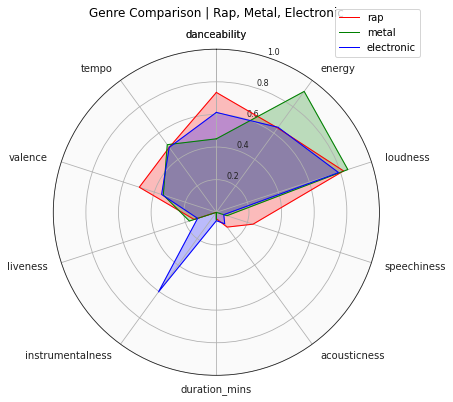

In [1784]:
# test plot
plot_three_genres('rap', 'metal','electronic')

In [1775]:
# plot all genres in a row --> based on SPOTIFY GENRES
genre_list = list(track_features['genre_spotify'].unique())

def plot_all_genres(genre_list):
    
    '''
    Build all radar graphs for all genres in a row.

    '''
    
    for i in range(0,len(genre_list)+1,3):
        genre_temp = genre_list[:i]
        if genre_temp == []:
            continue
        else:
            if len(genre_temp) > 3:
                genre_temp = genre_temp[-3:]
            else:
                genre_temp = genre_temp

            plot_three_genres(genre_temp[0], genre_temp[1], genre_temp[2])

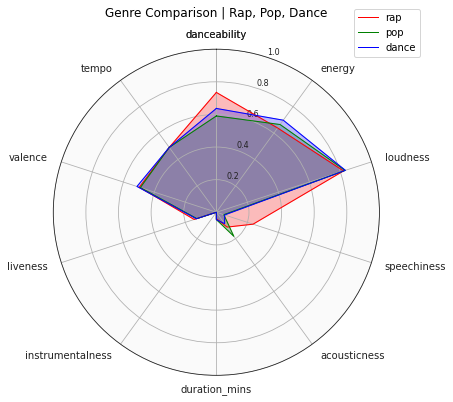

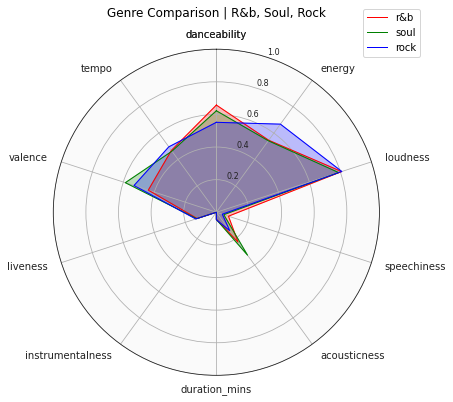

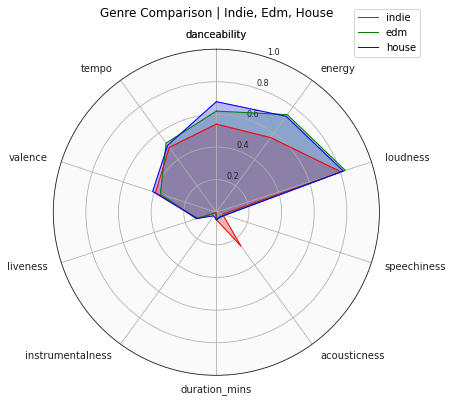

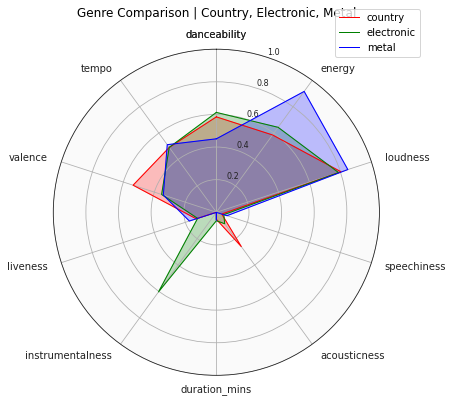

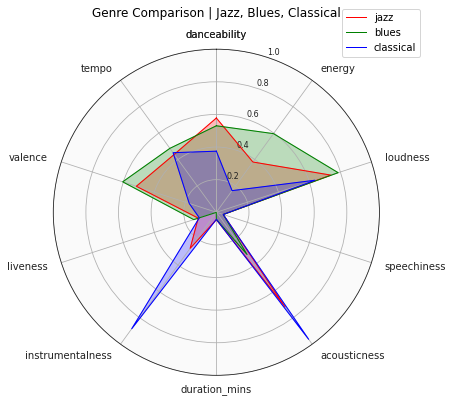

In [1776]:
plot_all_genres(genre_list)

----

The comparisong between Jazz, Blues and Classical music is pretty interesting. As expected, Classical music ranks high in acousticness and instrumentalness. Jazz ranks high in acousticness as well. Differently, and also in alignment with my expectations from my domain knowledge of music, the music profile of Blues is stronger on energy, tempo and valence. By observing the other music profiles by genre, I notice that indeed they do correspond to what we would expect from my domain knowledge of music and different music genres.

----

Let's now have a look at the distribution of tracks by genre.

In [1469]:
# check count of tracks by genre
track_features['genre'].value_counts()

blues         36885
metal         33918
soul          26671
rock          23269
jazz          22967
country       22644
indie         16407
dance         15373
electronic    14955
rap           13144
classical      9431
house          7858
r&b            6628
pop            3656
edm            1831
Name: genre, dtype: int64

In [1473]:
genres_df = track_features[['genre', 'danceability','energy', 'loudness','speechiness', 'acousticness',
                           'duration_mins','instrumentalness','liveness', 'valence', 'tempo']]

In [1474]:
genres_df

,genre,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
0,rap,0.790486,0.594,0.819698,0.050103,0.013655,0.037316,0.000000,0.1620,0.0628,0.532182
1,rap,0.561741,0.596,0.786765,0.387397,0.133534,0.028405,0.000000,0.1230,0.1450,0.316798
2,rap,0.923077,0.412,0.802466,0.127066,0.016566,0.050154,0.012613,0.1040,0.4230,0.634968
3,rap,0.767206,0.474,0.792483,0.151860,0.015261,0.038761,0.000000,0.1160,0.0542,0.311623
4,rap,0.419028,0.677,0.848118,0.262397,0.024900,0.063650,0.000000,0.0793,0.0853,0.706822
...,...,...,...,...,...,...,...,...,...,...,...
255632,metal,0.448381,0.960,0.866462,0.090083,0.000237,0.053772,0.000000,0.1310,0.4320,0.541585
255633,metal,0.302632,0.762,0.684629,0.944215,0.056124,0.005906,0.377377,0.6070,0.1570,0.331117
255634,metal,0.362348,0.819,0.846016,0.062603,0.002721,0.059938,0.003874,0.1050,0.0452,0.598546
255635,metal,0.479757,0.884,0.867822,0.104339,0.025502,0.051714,0.000000,0.0783,0.5240,0.735656


In [1476]:
genres_df = genres_df.groupby('genre', as_index=False).median()

In [1477]:
genres_df

,genre,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
0,blues,0.530364,0.5960,0.785343,0.044421,0.320281,0.043860,0.000990,0.146,0.604,0.484632
1,classical,0.374494,0.1640,0.635779,0.044008,0.962851,0.043738,0.882883,0.110,0.175,0.451487
2,country,0.585020,0.5860,0.803602,0.034917,0.260040,0.043212,0.000004,0.130,0.537,0.491519
3,dance,0.636640,0.6980,0.831984,0.053512,0.086044,0.045910,0.000003,0.129,0.512,0.491658
4,edm,0.620445,0.7400,0.831165,0.053616,0.040964,0.045538,0.006376,0.130,0.361,0.524357
5,electronic,0.612348,0.6440,0.787862,0.048037,0.087048,0.051923,0.603604,0.121,0.353,0.491908
6,house,0.678138,0.7275,0.818276,0.057335,0.035090,0.047559,0.026977,0.123,0.411,0.507954
7,indie,0.540486,0.5660,0.802961,0.040186,0.257028,0.045063,0.000635,0.123,0.392,0.491523
8,jazz,0.577935,0.3810,0.737714,0.044525,0.716867,0.045346,0.273273,0.117,0.516,0.438893
9,metal,0.450405,0.9160,0.847731,0.068595,0.000999,0.048856,0.001031,0.174,0.342,0.512344


## Track Recommendation Engine

## 1. From Mood/Personality to Optimal Music Profile

This first section, that will match the first action that the user will take on the app, will translate a user's mood/personality into a set of music features that will then serve as the imput of the recommendation engine. As part of this step, we will need to:
1. Map moods/personalities to music genres
2. Map music genres to music features

### Map moods/personalities to music genres

This has been the topic of investigation of [this study](https://www.jstor.org/stable/10.5406/amerjpsyc.123.2.0199). For the purpose of this initial prototype, we will provide an initial assessment of the map the moods and personality traits that are qualitatively expressed in the study to be able to map them to **user personas**.

In [1567]:
# import genre-persona map
genre_personas = pd.read_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/final/genre_personas.csv')

In [1568]:
genre_personas.head()

,music_genre,personality_trait,user_persona
0,pop,extroverted,A bubbly soda on a summer day
1,pop,honest,A bubbly soda on a summer day
2,pop,conventional,A bubbly soda on a summer day
3,pop,hardworking,A bubbly soda on a summer day
4,pop,high self-esteem,A bubbly soda on a summer day


The data contained in the first two columns of the dataframe has been taken from the Adrian C. North's study referenced above. I took this mapping of personality traits to music genre a step further and, also leveraging my domain knowledge of music, I identified a **user persona** that matches the personality traits related to a specific genre and that communicates at the same time a **palpable feeling** (e.g. a bubbly soda on a summer day for the pop genre). I also selected the user persona with the front-end of my final app in mind; since this user persona will be selected by the user in response to the question "How are you feeling", I wanted to make sure that the majority of the users can actually **relate to the personas** they'll select from. 

In [1569]:
genre_personas.shape

(39, 3)

In [1570]:
genre_personas = genre_personas.drop('personality_trait', axis=1)

In [1571]:
genre_personas

,music_genre,user_persona
0,pop,A bubbly soda on a summer day
1,pop,A bubbly soda on a summer day
2,pop,A bubbly soda on a summer day
3,pop,A bubbly soda on a summer day
4,pop,A bubbly soda on a summer day
5,pop,A bubbly soda on a summer day
6,rap/hip hop,A pair of confident kicks strutting down main ...
7,rap/hip hop,A pair of confident kicks strutting down main ...
8,country,A smokey mashmellows on crackling campfire
9,country,A smokey mashmellows on crackling campfire


In [1572]:
genre_personas.drop_duplicates(inplace=True)

In [1573]:
genre_personas.reset_index(drop = True,inplace = True)

In [1574]:
genre_personas

,music_genre,user_persona
0,pop,A bubbly soda on a summer day
1,rap/hip hop,A pair of confident kicks strutting down main ...
2,country,A smokey mashmellows on crackling campfire
3,rock/metal,A freshly sprayed graffiti in a narrow alleyway
4,indie,A hot cappuccino on a late fall day
5,dance/electronic,A freshly cracked coconut on a tropical island
6,classical,A salty beach on a low tide
7,jazz/blues/soul,The organized chaos of a Jackson Pollock


> This table will allow us to **<mark>map a user persona (selected by the user) to a music genre<mark/>**. Hence, this table is representative of the first step in the user flow on the app. 

Let's now import a table that maps Spotify genres to the genres as presented in the Adrian C. North's study on Individual Differences in Musical Taste. The objective is to rename the *genre* column in the tracks df with the name related to the genre as presented in the study. This is needed to execute the right mapping between genre and user persona.

In [1577]:
# import spotify genre-study genre map
spotify_study_genre = pd.read_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/final/study_spotify_map.csv')

In [1578]:
spotify_study_genre

,genre,genre_study
0,pop,pop
1,rap,rap/hip hop
2,r&b,rap/hip hop
3,country,country
4,rock,rock/metal
5,metal,rock/metal
6,indie,indie
7,dance,dance/electronic
8,edm,dance/electronic
9,electronic,dance/electronic


As we see here, the music genres mentioned in the study do not perfectly correspond to the music genres as presented on Spotify. Therefore, in building the recommendation engine, we will make some **music genre aggregation** to respect the genre separation derived as part of the study and which we will need to map moods to genres.

In [1587]:
# merge dfs
genre_personas = spotify_study_genre.merge(genre_personas, left_on = 'genre_study', right_on = 'music_genre', how = 'left')

In [1588]:
genre_personas.rename(columns={"genre": "genre_spotify"},inplace=True)

In [1589]:
genre_personas.drop('music_genre', axis=1, inplace = True)

In [1590]:
genre_personas

,genre_spotify,genre_study,user_persona
0,pop,pop,A bubbly soda on a summer day
1,rap,rap/hip hop,A pair of confident kicks strutting down main ...
2,r&b,rap/hip hop,A pair of confident kicks strutting down main ...
3,country,country,A smokey mashmellows on crackling campfire
4,rock,rock/metal,A freshly sprayed graffiti in a narrow alleyway
5,metal,rock/metal,A freshly sprayed graffiti in a narrow alleyway
6,indie,indie,A hot cappuccino on a late fall day
7,dance,dance/electronic,A freshly cracked coconut on a tropical island
8,edm,dance/electronic,A freshly cracked coconut on a tropical island
9,electronic,dance/electronic,A freshly cracked coconut on a tropical island


Let's now define the function extracting the **first recommendation to the user**. Importantly, this recommendation will not be visible to the user in the app, but it will lead to the visibile recommendation of three songs that are the closest (in cosine similarity) to the genre (mapped from the selected persona). 

In [1746]:
# save to pkl to reference to while creating the streamlit app
genre_personas.to_pickle('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/genre_personas.pkl')

In [1858]:
# switch to protocol 2 to avoid the unsupported pickle 5 error in streamlit
genre_personas.to_pickle('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/genre_personas.bz2')

In [1870]:
# switch to csv because of pickle 5 error in streamlit
genre_personas.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/genre_personas.csv')

In [1591]:
# first recommendation
def recommender_personas(user_persona):
    
    '''
    
    Function to return the first recommendation:
    - user selects the persona that they identify
    with at a specific moment or day
    - function returns the music genre they 
    are likely to appreciate listening to 
    [source: Adrian C. North's tudy on Individual
    differences in musical taste]

    '''
    
    idx_persona = genre_personas.index[genre_personas['user_persona'] == user_persona]
    recommendation_genre = genre_personas.iloc[idx_persona]['genre_study'].values[0]
    
    return recommendation_genre

In [1732]:
# test recommender #1 on one persona
recommender_personas('The organized chaos of a Jackson Pollock')

'jazz/blues/soul'

In [1729]:
# create a function to plot the genre that was mapped to the user persona
def plot_radar_mapped_genre(mapped_genre):
   
    '''
    -------------------------------------------------
    INPUT: genre that was mapped to the user persona
    
    -------------------------------------------------
    OUTPUT: radar graph showing the music profile 
    corresponding to the genre the user has been
    mapped to.
    
    -------------------------------------------------
    '''
    
    # identify labels to be plotted
    labels = ['danceability','energy', 'loudness','speechiness', 'acousticness',
                  'duration_mins','instrumentalness','liveness', 'valence', 'tempo']
    
    num_vars = len(labels)

    # calculate angle for each music feature
    angles=[n/float(num_vars)*2*pi for n in range(num_vars)]
    angles+=angles[:1]
    
    # set figure parameters
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # helper function to plot each genre on the radar chart
    def add_to_radar(genre, color):
        
        '''
        Creates a single radar graph for a single 
        music genre.

        Resulting chart is to be interpreted as the
        "music profile" characterizing a specific genre. 
        '''
        
        # filter tracks df for one genre only
        genre_df = track_features[track_features['genre_study'] == str(genre)]
        
        # compute median of every music feature for a specific genre
        values = list(genre_df[labels].median())
        values+=values[:1]

        ax.plot(angles, values, color=color, linewidth=1, label=genre)
        ax.fill(angles, values, color=color, alpha=0.25)

    # add each genre to the radar graph
    add_to_radar(mapped_genre, 'green')

    # find polar coordinates 
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # draw axis lines for each angle and label
    labels+=labels[:1] # ensure that labels and angles have the same dimensions
    ax.set_thetagrids(np.degrees(angles), labels)

    # go through labels and adjust alignment based on where it is in the circle
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # set position of y-labels (0-100) to be in the middle of the first two axes.
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(180 / num_vars)

    # add some custom styling
    ax.tick_params(colors='#222222')         # color of tick labels
    ax.tick_params(axis='y', labelsize=8)    # y-axis labels
    ax.spines['polar'].set_color('#222222')  # color of outermost gridline (spine)
    ax.set_facecolor('#FAFAFA')              # background color inside the circle itself

    # set title and a legend
    ax.set_title('Your Music Taste Graph', y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.14));

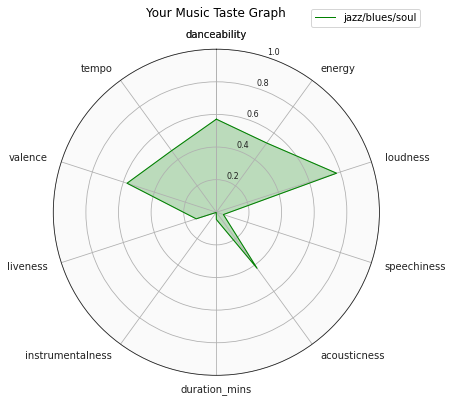

In [1731]:
# test function
plot_radar_mapped_genre('jazz/blues/soul')

----

This conclude the **<mark>first step in the recommendation engine<mark/>**. The user will select the persona/mood that best represent them at a specific moment and they will be **mapped to a music genre**.

----

In [1595]:
track_features = track_features.merge(genre_personas[['genre_spotify','genre_study']], left_on = 'genre', right_on = 'genre_spotify', how = 'left')

In [1596]:
# drop duplicate col
track_features.drop('genre', axis=1, inplace = True)

In [1597]:
track_features.columns

Index(['id', 'track_name', 'artist_name', 'album_name', 'track_popularity',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'duration_mins', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre_spotify', 'genre_study'],
      dtype='object')

In [1598]:
# rearrange cols
track_features = track_features[['id', 'track_name', 'artist_name', 'album_name', 'track_popularity',
                                 'genre_spotify', 'genre_study','danceability', 'energy', 'loudness', 
                                 'speechiness', 'acousticness','duration_mins', 'instrumentalness', 
                                 'liveness', 'valence', 'tempo',]]

In [1603]:
track_features.head()

,id,track_name,artist_name,album_name,track_popularity,genre_spotify,genre_study,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
0,3aQem4jVGdhtg116TmJnHz,What’s Next,Drake,Scary Hours 2,82,rap,rap/hip hop,0.790486,0.594,0.819698,0.050103,0.013655,0.037316,0.000000,0.1620,0.0628,0.532182
1,2yg9UN4eo5eMVJ7OB4RWj3,Survival,Drake,Scorpion,59,rap,rap/hip hop,0.561741,0.596,0.786765,0.387397,0.133534,0.028405,0.000000,0.1230,0.1450,0.316798
2,0TlLq3lA83rQOYtrqBqSct,Nonstop,Drake,Scorpion,77,rap,rap/hip hop,0.923077,0.412,0.802466,0.127066,0.016566,0.050154,0.012613,0.1040,0.4230,0.634968
3,3szf2z1Cy1QMrtHrbn8rz9,Elevate,Drake,Scorpion,62,rap,rap/hip hop,0.767206,0.474,0.792483,0.151860,0.015261,0.038761,0.000000,0.1160,0.0542,0.311623
4,5Psnhdkyanjpgc2P8A5TSM,Emotionless,Drake,Scorpion,65,rap,rap/hip hop,0.419028,0.677,0.848118,0.262397,0.024900,0.063650,0.000000,0.0793,0.0853,0.706822


### Map music genre to music features

Now we will create a dataframe mapping music genre (rows) to music features (cols). Thanks to this dataframe, we will be able to decipher a user's mood/personality in terms of music genre and the music features that compose a *music genre profile*.

In [1604]:
# genre df based on spotify genres
genres_df

,genre,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
0,blues,0.530364,0.5960,0.785343,0.044421,0.320281,0.043860,0.000990,0.146,0.604,0.484632
1,classical,0.374494,0.1640,0.635779,0.044008,0.962851,0.043738,0.882883,0.110,0.175,0.451487
2,country,0.585020,0.5860,0.803602,0.034917,0.260040,0.043212,0.000004,0.130,0.537,0.491519
3,dance,0.636640,0.6980,0.831984,0.053512,0.086044,0.045910,0.000003,0.129,0.512,0.491658
4,edm,0.620445,0.7400,0.831165,0.053616,0.040964,0.045538,0.006376,0.130,0.361,0.524357
5,electronic,0.612348,0.6440,0.787862,0.048037,0.087048,0.051923,0.603604,0.121,0.353,0.491908
6,house,0.678138,0.7275,0.818276,0.057335,0.035090,0.047559,0.026977,0.123,0.411,0.507954
7,indie,0.540486,0.5660,0.802961,0.040186,0.257028,0.045063,0.000635,0.123,0.392,0.491523
8,jazz,0.577935,0.3810,0.737714,0.044525,0.716867,0.045346,0.273273,0.117,0.516,0.438893
9,metal,0.450405,0.9160,0.847731,0.068595,0.000999,0.048856,0.001031,0.174,0.342,0.512344


In [1605]:
# genre df based on study genres
genres_study_df = track_features[['genre_study', 'danceability','energy', 'loudness','speechiness', 'acousticness',
                                  'duration_mins','instrumentalness','liveness', 'valence', 'tempo']]


In [1606]:
# median of music features by genre
genres_study_df = genres_study_df.groupby('genre_study', as_index=False).median()

In [1607]:
genres_study_df

,genre_study,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
0,classical,0.374494,0.164,0.635779,0.044008,0.962851,0.043738,0.882883,0.110,0.175,0.451487
1,country,0.585020,0.586,0.803602,0.034917,0.260040,0.043212,0.000004,0.130,0.537,0.491519
2,dance/electronic,0.635628,0.689,0.816638,0.051860,0.071185,0.047798,0.007548,0.124,0.431,0.499558
3,indie,0.540486,0.566,0.802961,0.040186,0.257028,0.045063,0.000635,0.123,0.392,0.491523
4,jazz/blues/soul,0.570850,0.525,0.775206,0.045455,0.424699,0.044426,0.001181,0.130,0.576,0.466826
5,pop,0.590587,0.665,0.830322,0.048089,0.182229,0.044777,0.000001,0.126,0.490,0.491722
6,rap/hip hop,0.710526,0.610,0.815958,0.175620,0.141566,0.041011,0.000000,0.136,0.476,0.483415
7,rock/metal,0.486842,0.841,0.835105,0.051550,0.009900,0.047852,0.000204,0.153,0.403,0.506953


----

In this first section we created the function that will extract the music genre from the user persona selected by the user. Hence, we completed the first step of our recommendation system. As a reminder, this step will be executed in the back end but will not be visibile to the user. 

----

## 2. From Optimal Music Profile to Top 3 tracks

Let's now build the recommendation engine that, from the optimal genre (derived from the user persona/mood selected by the user), generates a list of **three songs that are the closest to the music genre's dimensions from a <mark>cosine similarity standpoint<mark/>**. In the front-end, the user will then have to select the song that is the most appealing to them at that point in time.<br/>

Cosine similarity is a metric used to measure how similar two items are. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The output value ranges from 0–1 with 0 referring to a lack of similarity and 1 referring to a perfect similarity.

In [1632]:
# set genre as index to compute cosine similarity
genres_study_indexed_df = genres_study_df.set_index('genre_study') 

In [1633]:
genres_study_indexed_df

,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
genre_study,,,,,,,,,,
classical,0.374494,0.164,0.635779,0.044008,0.962851,0.043738,0.882883,0.110,0.175,0.451487
country,0.585020,0.586,0.803602,0.034917,0.260040,0.043212,0.000004,0.130,0.537,0.491519
dance/electronic,0.635628,0.689,0.816638,0.051860,0.071185,0.047798,0.007548,0.124,0.431,0.499558
indie,0.540486,0.566,0.802961,0.040186,0.257028,0.045063,0.000635,0.123,0.392,0.491523
jazz/blues/soul,0.570850,0.525,0.775206,0.045455,0.424699,0.044426,0.001181,0.130,0.576,0.466826
pop,0.590587,0.665,0.830322,0.048089,0.182229,0.044777,0.000001,0.126,0.490,0.491722
rap/hip hop,0.710526,0.610,0.815958,0.175620,0.141566,0.041011,0.000000,0.136,0.476,0.483415
rock/metal,0.486842,0.841,0.835105,0.051550,0.009900,0.047852,0.000204,0.153,0.403,0.506953


In [1642]:
# set genre as index to compute cosine similarity
track_features_indexed_df = track_features.drop(columns = ['track_name','artist_name','album_name','track_popularity','genre_spotify','genre_study']).set_index('id') 

In [1643]:
track_features_indexed_df

,danceability,energy,loudness,speechiness,acousticness,duration_mins,instrumentalness,liveness,valence,tempo
id,,,,,,,,,,
3aQem4jVGdhtg116TmJnHz,0.790486,0.594,0.819698,0.050103,0.013655,0.037316,0.000000,0.1620,0.0628,0.532182
2yg9UN4eo5eMVJ7OB4RWj3,0.561741,0.596,0.786765,0.387397,0.133534,0.028405,0.000000,0.1230,0.1450,0.316798
0TlLq3lA83rQOYtrqBqSct,0.923077,0.412,0.802466,0.127066,0.016566,0.050154,0.012613,0.1040,0.4230,0.634968
3szf2z1Cy1QMrtHrbn8rz9,0.767206,0.474,0.792483,0.151860,0.015261,0.038761,0.000000,0.1160,0.0542,0.311623
5Psnhdkyanjpgc2P8A5TSM,0.419028,0.677,0.848118,0.262397,0.024900,0.063650,0.000000,0.0793,0.0853,0.706822
...,...,...,...,...,...,...,...,...,...,...
6VP69eiW8k8OVUjS2lBYKy,0.448381,0.960,0.866462,0.090083,0.000237,0.053772,0.000000,0.1310,0.4320,0.541585
3GrFAJiT7FWRBKuLqVHy3b,0.302632,0.762,0.684629,0.944215,0.056124,0.005906,0.377377,0.6070,0.1570,0.331117
326QxhmInOvbgbaNzeHxRz,0.362348,0.819,0.846016,0.062603,0.002721,0.059938,0.003874,0.1050,0.0452,0.598546


Let's start by creating a function that will return a dataframe with some useful information about the most similar (in terms of cosine similarity) tracks to the profile of the music genre selected above.

In [1681]:
def get_cosim_genre_tracks(genre, df_music_genres = genres_study_indexed_df, df_songs = track_features_indexed_df, num_tracks = 3):
    
    '''
    
    Function to return the second recommendation,
    which will be visible to the user.
    
    --------------------------------------------
    INPUTS
    - genre from step 1 in the recommendation engine
    [mapping from user persona to music genre]
    - df of genre and music features
    - df of tracks and music features
    - num tracks with highest cosine similarity
    
    --------------------------------------------
    OUTPUTS
    - top 3 songs with the highest cosine similarity
    to the chosen genre

    '''
    
    # temporary df based on the genre resulting from the first genre recommendation
    genre_temp = df_music_genres.loc[[str(genre)]]
    
    # create arrays of music features
    genre_array = np.array(genre_temp.T).reshape(1,-1)
    tracks_array = df_songs.values
    
    # compute cosine similarity
    cosim_scores = cosine_similarity(genre_array, tracks_array).flatten()
    tracks_similar_array = df_songs.index.values
    
    # initialize df results including most similar tracks 
    df_result = pd.DataFrame(data = {'tracks': tracks_similar_array,
                                     'cosim_' + genre: cosim_scores})
    
    # sort tracks and take only first 3
    df_result = df_result.sort_values(by='cosim_' + genre, ascending=False).head(num_tracks)
    
    # add new columns to to the df result dataframe
    list_top_3 = df_result['tracks'].tolist()
    
    # initialize empty dictionaries
    title_dict = {}
    album_dict = {}
    artist_dict = {}
    genre_dict = {}
    popularity_dict = {}
    
    # for the top 3 tracks --> look for additional features
    for track_id in list_top_3:
        title_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['track_name'].values[0]
        album_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['album_name'].values[0]
        artist_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['artist_name'].values[0]
        genre_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['genre_study'].values[0]
        popularity_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['track_popularity'].values[0]
    
    # add new cols
    df_result['title'] = df_result['tracks'].map(title_dict)
    df_result['album'] = df_result['tracks'].map(album_dict)
    df_result['artist'] = df_result['tracks'].map(artist_dict)
    df_result['genre'] = df_result['tracks'].map(genre_dict)
    df_result['popularity'] = df_result['tracks'].map(popularity_dict)
    
    
    # reorganize df
    df_result = df_result[['tracks','title','album',
                             'artist','genre', 'popularity',
                             'cosim_' + genre]]
    
    return df_result.reset_index(drop=True)

In [1717]:
# test function
get_cosim_genre_tracks('jazz/blues/soul')

,tracks,title,album,artist,genre,popularity,cosim_jazz/blues/soul
0,6GY7yKOI1ZTpXk6xSnjzUK,"Tears Dry On Their Own - Live Jo Whiley, BBC L...",At The BBC,Amy Winehouse,jazz/blues/soul,37,0.999342
1,2qhR4aymUGDfacDT6pzWf7,Fly Me To The Moon (In Other Words),Fly Me To The Moon,Bobby Womack,jazz/blues/soul,57,0.999074
2,0Unzrf3dd0arjJaQuC1HVj,The Same Rope,Tell Mama: The Complete Muscle Shoals Sessions...,Etta James,jazz/blues/soul,5,0.999053


In order to produce a more succinct result for the app, let's now create the helper function that will allow us to only see the song title of the top 3 songs that are most similar to the selected music genre.

In [1756]:
# pickle for use in streamlit
genres_study_indexed_df.to_pickle('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/genres_study_indexed_df.pkl')

In [1757]:
# pickle for use in streamlit
track_features_indexed_df.to_pickle('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/track_features_indexed_df.pkl')

In [1758]:
# pickle for use in streamlit
track_features.to_pickle('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/track_features.pkl')

In [1867]:
# switch to protocol 2 to avoid the unsupported pickle 5 error in streamlit
genres_study_indexed_df.to_pickle('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/genres_study_indexed_df.bz2')

In [1868]:
# switch to protocol 2 to avoid the unsupported pickle 5 error in streamlit
track_features_indexed_df.to_pickle('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/track_features_indexed_df.bz2')

In [1869]:
# switch to protocol 2 to avoid the unsupported pickle 5 error in streamlit
track_features.to_pickle('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/track_features.bz2')

In [1874]:
# switch to csv to avoid the unsupported pickle 5 error in streamlit
genres_study_indexed_df.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/genres_study_indexed_df.csv',
                               index_label='genre_study')

In [1875]:
# switch to csv to avoid the unsupported pickle 5 error in streamlit
track_features_indexed_df.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/track_features_indexed_df.csv',
                                index_label='id')

In [1873]:
# switch to csv to avoid the unsupported pickle 5 error in streamlit
track_features.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/Engineering-Spotify/pickle_files_for_app/track_features.csv')

In [1712]:
def get_cosim_genre_tracks_simple(genre, df_music_genres = genres_study_indexed_df, df_songs = track_features_indexed_df, num_tracks = 3):
    
    '''
    
    Function to return the second recommendation,
    which will be visible to the user.
    This is a more succinct version of the fx 
    above as it only prints the recommended
    songs titles.
    
    --------------------------------------------
    INPUTS
    - genre from step 1 in the recommendation engine
    [mapping from user persona to music genre]
    - df of genre and music features
    - df of tracks and music features
    - num tracks with highest cosine similarity
    
    --------------------------------------------
    OUTPUTS
    - top 3 songs with the highest cosine similarity
    to the chosen genre

    '''
    
    # temporary df based on the genre resulting from the first genre recommendation
    genre_temp = df_music_genres.loc[[str(genre)]]
    
    # create arrays of music features
    genre_array = np.array(genre_temp.T).reshape(1,-1)
    tracks_array = df_songs.values
    
    # compute cosine similarity
    cosim_scores = cosine_similarity(genre_array, tracks_array).flatten()
    tracks_similar_array = df_songs.index.values
    
    # initialize df results including most similar tracks 
    df_result = pd.DataFrame(data = {'tracks': tracks_similar_array,
                                     'cosim_' + genre: cosim_scores})
    
    # sort tracks and take only first 3
    df_result = df_result.sort_values(by='cosim_' + genre, ascending=False).head(num_tracks)
    
    # add new columns to to the df result dataframe
    list_top_3 = df_result['tracks'].tolist()
    
    # initialize empty dictionaries
    title_dict = {}
    artist_dict = {}
    
    # for the top 3 tracks --> look for additional features
    for track_id in list_top_3:
        title_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['track_name'].values[0]
        artist_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['artist_name'].values[0]
    
    # add new cols
    df_result['title'] = df_result['tracks'].map(title_dict)
    df_result['artist'] = df_result['tracks'].map(artist_dict)
    
    # collect song titles
    list_song_titles = df_result['title'].tolist()
    list_artists = df_result['artist'].tolist()
    
    for i in range(len(list_song_titles)):
        print(list_song_titles[i], " | ", list_artists[i])

In [1713]:
# test function
get_cosim_genre_tracks_simple('jazz/blues/soul')

Tears Dry On Their Own - Live Jo Whiley, BBC Live Lounge Session / 2007  |  Amy Winehouse
Fly Me To The Moon (In Other Words)  |  Bobby Womack
The Same Rope  |  Etta James


In [1741]:
# create a function to plot the seed track chosen by the user
def plot_radar_seed_track(seed_track_id):
   
    '''
    -------------------------------------------------
    INPUT: seed track id selecte in step 2
    
    -------------------------------------------------
    OUTPUT: radar graph showing the music profile 
    corresponding to the seed track
    
    -------------------------------------------------
    '''
    
    # find seed track title
    seed_track_title = track_features.iloc[track_features[track_features['id']==seed_track_id].index.values]['track_name'].values[0]
    
    # identify labels to be plotted
    labels = ['danceability','energy', 'loudness','speechiness', 'acousticness',
                  'duration_mins','instrumentalness','liveness', 'valence', 'tempo']
    
    num_vars = len(labels)

    # calculate angle for each music feature
    angles=[n/float(num_vars)*2*pi for n in range(num_vars)]
    angles+=angles[:1]
    
    # set figure parameters
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # helper function to plot seed track on the radar chart
    def add_to_radar(seed_track_id, color):
        
        '''
        Creates a single radar graph for a single 
        music genre.

        Resulting chart is to be interpreted as the
        "music profile" characterizing a specific genre. 
        '''
        
        # filter tracks df for the seed track only
        seed_track_df = track_features[track_features['id'] == str(seed_track_id)]
        
        # compute median of every music feature for the seed track
        values = list(seed_track_df[labels].median())
        values+=values[:1]

        ax.plot(angles, values, color=color, linewidth=1)
        ax.fill(angles, values, color=color, alpha=0.25)

    # add seed track to the radar graph
    add_to_radar(seed_track_id, 'blue')

    # find polar coordinates 
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # draw axis lines for each angle and label
    labels+=labels[:1] # ensure that labels and angles have the same dimensions
    ax.set_thetagrids(np.degrees(angles), labels)

    # go through labels and adjust alignment based on where it is in the circle
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # set position of y-labels (0-100) to be in the middle of the first two axes
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(180 / num_vars)

    # add some custom styling
    ax.tick_params(colors='#222222')         # color of tick labels
    ax.tick_params(axis='y', labelsize=8)    # y-axis labels
    ax.spines['polar'].set_color('#222222')  # color of outermost gridline (spine)
    ax.set_facecolor('#FAFAFA')              # background color inside the circle itself

    # set title and a legend
    ax.set_title('Track Music Profile | '+ str(seed_track_title).capitalize(), y=1.08);

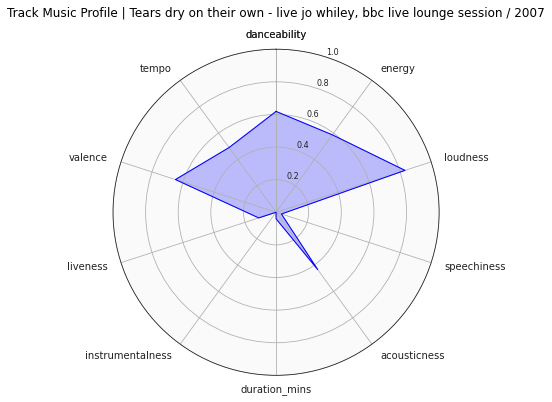

In [1742]:
# test fucntion
plot_radar_seed_track('6GY7yKOI1ZTpXk6xSnjzUK')

----

This section ends the **<mark>second step of the recommendation engine<mark/>**, mapping the optimal genre resulting from the first step into a **list of the top 3 tracks** that are most similar to it. The user will select the song that is the most appealing to them to access the final playlist.

----

## 3. From Chosen track to Top 10 Playlist

This last step of the recommendation engine will present the actual recommendation to the user: the **top 10 songs that best match their mood in that specific moment**. In the back end, the algorithm will register the song that the user selected in step 2 above (i.e. *seed song* in a more technical term) and will find 10 songs that best match the *seed song*'s profile in terms of the 10 Spotify music features.

In [1786]:
def get_cosim_seed_tracks(track, df_songs = track_features_indexed_df, num_tracks = 10):
    
    '''
    
    Function to return the final recommendation,
    which will be visible to the user.
    
    --------------------------------------------
    INPUTS
    - song from step 2 in the recommendation engine
    [mapping from user persona to music genre]
    - df of tracks and music features
    - num tracks with highest cosine similarity
    
    --------------------------------------------
    OUTPUTS
    - top 10 songs with the highest cosine similarity
    to the chosen song

    '''
    
    # temporary df based on the seed song resulting from step 2
    seed_temp = df_songs.loc[[track]]
    
    # create arrays of music features
    seed_array = np.array(seed_temp.T).reshape(1,-1)
    tracks_array = df_songs.values
    
    # compute cosine similarity
    cosim_scores = cosine_similarity(seed_array, tracks_array).flatten()
    tracks_similar_array = df_songs.index.values
    
    # initialize df results including most similar tracks 
    df_result = pd.DataFrame(data = {'tracks': tracks_similar_array,
                                     'cosim': cosim_scores})
    
    # sort tracks and take only first 10
    df_result = df_result.sort_values(by='cosim', ascending=False).head(num_tracks) #add (num_tracks+1) if want to remove seed song
    
    ## run this line if want to remove the seed song
#     df_result = df_result.iloc[1: , :]
    
    # add new columns to to the df result dataframe
    list_top_10 = df_result['tracks'].tolist()
    
    # initialize empty dictionaries
    title_dict = {}
    album_dict = {}
    artist_dict = {}
    genre_dict = {}
    popularity_dict = {}
    
    # for the top 3 tracks --> look for additional features
    for track_id in list_top_10:
        title_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['track_name'].values[0]
        album_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['album_name'].values[0]
        artist_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['artist_name'].values[0]
        genre_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['genre_study'].values[0]
        popularity_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['track_popularity'].values[0]
    
    # add new cols
    df_result['title'] = df_result['tracks'].map(title_dict)
    df_result['album'] = df_result['tracks'].map(album_dict)
    df_result['artist'] = df_result['tracks'].map(artist_dict)
    df_result['genre'] = df_result['tracks'].map(genre_dict)
    df_result['popularity'] = df_result['tracks'].map(popularity_dict)
    
    
    # reorganize df
    df_result = df_result[['tracks','title','album',
                             'artist','genre', 'popularity',
                             'cosim']]
    
    return df_result.reset_index(drop=True)

In [1791]:
get_cosim_seed_tracks('0Unzrf3dd0arjJaQuC1HVj') #6GY7yKOI1ZTpXk6xSnjzUK

,tracks,title,album,artist,genre,popularity,cosim
0,0Unzrf3dd0arjJaQuC1HVj,The Same Rope,Tell Mama: The Complete Muscle Shoals Sessions...,Etta James,jazz/blues/soul,5,1.000000
1,6NHPTrW2SdGU5mcgyuomUH,The Same Rope,Tell Mama,Etta James,jazz/blues/soul,25,0.999571
2,6rKD9axpeGAKgytwctW7f4,Heatwave,Little Oblivions,Julien Baker,indie,47,0.999160
3,7K2Amc7iEsALLY8vte56TQ,The Same Rope,Heart & Soul: A Retrospective,Etta James,jazz/blues/soul,11,0.999045
4,0V9m4bmLvvcfsJDtjAW9Op,My Block,The Best Of The Chiffons,The Chiffons,jazz/blues/soul,8,0.999043
5,1zxEK72tmfJ1zVGp0rvz7I,Streets Of Fire,Streets Of Fire,Dobie Gray,jazz/blues/soul,11,0.998889
6,4qSfsFRRSJRaA8UhPGiq7s,Storms Never Last,Pleasure & Pain,Dr. Hook,country,44,0.998837
7,5plZsXyfMyDP5bvDIGrqOz,The Beauty Way,Delirium Tremolos,Ray Wylie Hubbard,country,21,0.998801
8,5nwlKkZjxYQCfqstiyFNwA,That's All It Took,Sleepless Nights,Patty Loveless,country,11,0.998694
9,3bFx1qXpfk03qE6nD4st4k,Ballad of Big Nothing,Either/Or: Expanded Edition,Elliott Smith,indie,20,0.998534


Let's now build a simpler version of the function above, that only prints the song title and artist. This format will be more appropriate for the UI of an app. 

In [1788]:
def get_cosim_seed_tracks_simple(track, df_songs = track_features_indexed_df, num_tracks = 10):
    
    '''
    
    Function to return the final recommendation,
    which will be visible to the user.
    This is a more succinct version of the fx 
    above as it only prints the recommended
    songs titles.
    
    --------------------------------------------
    INPUTS
    - song from step 2 in the recommendation engine
    [mapping from user persona to music genre]
    - df of tracks and music features
    - num tracks with highest cosine similarity
    
    --------------------------------------------
    OUTPUTS
    - top 10 songs with the highest cosine similarity
    to the chosen song

    '''
    
    # temporary df based on the seed song resulting from step 2
    seed_temp = df_songs.loc[[track]]
    
    # create arrays of music features
    seed_array = np.array(seed_temp.T).reshape(1,-1)
    tracks_array = df_songs.values
    
    # compute cosine similarity
    cosim_scores = cosine_similarity(seed_array, tracks_array).flatten()
    tracks_similar_array = df_songs.index.values
    
    # initialize df results including most similar tracks 
    df_result = pd.DataFrame(data = {'tracks': tracks_similar_array,
                                     'cosim': cosim_scores})
    
    # sort tracks and take only first 10
    df_result = df_result.sort_values(by='cosim', ascending=False).head(num_tracks) #add (num_tracks+1) if want to remove seed song
    
    ## run this line if want to remove the seed song
#     df_result = df_result.iloc[1: , :]
    
    # add new columns to to the df result dataframe
    list_top_10 = df_result['tracks'].tolist()
    
    # initialize empty dictionaries
    title_dict = {}
    artist_dict = {}
    
    # for the top 3 tracks --> look for additional features
    for track_id in list_top_10:
        title_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['track_name'].values[0]
        artist_dict[track_id] = track_features.iloc[track_features[track_features['id']==track_id].index.values]['artist_name'].values[0]
        
    # add new cols
    df_result['title'] = df_result['tracks'].map(title_dict)
    df_result['artist'] = df_result['tracks'].map(artist_dict)
    
    # collect song titles
    list_song_titles = df_result['title'].tolist()
    list_artists = df_result['artist'].tolist()
    
    for i in range(len(list_song_titles)):
        print(list_song_titles[i], " | ", list_artists[i])

In [1789]:
# test function
get_cosim_seed_tracks_simple('6GY7yKOI1ZTpXk6xSnjzUK')

Tears Dry On Their Own - Live Jo Whiley, BBC Live Lounge Session / 2007  |  Amy Winehouse
The Beauty Way  |  Ray Wylie Hubbard
I Like It Like That  |  The Miracles
Fly Me To The Moon (In Other Words)  |  Bobby Womack
Dirty Town  |  Mother Mother
Rolling Down A Mountainside  |  Isaac Hayes
Hi De Ho  |  Carole King
Going, Going, Gone  |  Marty Stuart
You Say All The Nice Things  |  Ty Segall
Hang Onto Yourself  |  The Sheepdogs


----

This steps brings us to the **<mark>final recommendation<mark/>**, which consists of the 10 most similar songs to the one seed song selected by the user in step 2. 

----